In [0]:
!pip install mlflow

     |█████▉                          | 3.6 MB 6.8 MB/s eta 0:00:03

*** WARNING: max output size exceeded, skipping output. ***

     |████████████████████████████████| 3.1 MB 43.6 MB/s 
     |████████████████████████████████| 41 kB 194 kB/s 
     |████████████████████████████████| 78 kB 10.0 MB/s 
     |████████████████████████████████| 226 kB 51.2 MB/s 
     |████████████████████████████████| 97 kB 3.7 MB/s 
     |████████████████████████████████| 133 kB 53.3 MB/s 
     |████████████████████████████████| 62 kB 2.3 MB/s 
     |████████████████████████████████| 52 kB 2.4 MB/s 
     |████████████████████████████████| 202 kB 55.3 MB/s 
     |████████████████████████████████| 614 kB 45.5 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Not uninstalling typing-extensions at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-ee60198f-7b6c-4f91-975b-60d467d6f236
    Can't

In [0]:
# Import required libraries
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col, lit
import mlflow
import mlflow.spark
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
# Create a Spark session
spark = SparkSession.builder.appName("ALS Recommender").getOrCreate()

In [0]:
# Load the data
df = spark.read.csv("/FileStore/tables/steam_200k.csv", header=False, inferSchema=True)


In [0]:
print("Schema:")
df.printSchema()

print("Number of records:", df.count())
print("Records: ")
df.show(5)

Schema:
root
 |-- _c0: integer (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: double (nullable = true)

Number of records: 200000
Records: 
+---------+--------------------+--------+-----+
|      _c0|                 _c1|     _c2|  _c3|
+---------+--------------------+--------+-----+
|151603712|The Elder Scrolls...|purchase|  1.0|
|151603712|The Elder Scrolls...|    play|273.0|
|151603712|           Fallout 4|purchase|  1.0|
|151603712|           Fallout 4|    play| 87.0|
|151603712|               Spore|purchase|  1.0|
+---------+--------------------+--------+-----+
only showing top 5 rows



In [0]:
# Rename the column names to preferrable ones
df = df.withColumnRenamed("_c0", "user").withColumnRenamed("_c1", "game").withColumnRenamed("_c2", "behaviour").withColumnRenamed("_c3", "value")

In [0]:
print("Number of records:", df.count())
print("Dataframe: ")
df.show(5)

Number of records: 200000
Dataframe: 
+---------+--------------------+---------+-----+
|     user|                game|behaviour|value|
+---------+--------------------+---------+-----+
|151603712|The Elder Scrolls...| purchase|  1.0|
|151603712|The Elder Scrolls...|     play|273.0|
|151603712|           Fallout 4| purchase|  1.0|
|151603712|           Fallout 4|     play| 87.0|
|151603712|               Spore| purchase|  1.0|
+---------+--------------------+---------+-----+
only showing top 5 rows



In [0]:
from pyspark.sql import functions as F
from pyspark.sql import Window

# Filter for 'purchase' and 'play' behavior and select required columns
purchase_df = df.filter(col("behaviour") == "purchase").select("user", "game", "value")
play_df = df.filter(col("behaviour") == "play").select("user", "game", "value")

In [0]:
print(f"Purchase df: {purchase_df.show(10)}")

+---------+--------------------+-----+
|     user|                game|value|
+---------+--------------------+-----+
|151603712|The Elder Scrolls...|  1.0|
|151603712|           Fallout 4|  1.0|
|151603712|               Spore|  1.0|
|151603712|   Fallout New Vegas|  1.0|
|151603712|       Left 4 Dead 2|  1.0|
|151603712|            HuniePop|  1.0|
|151603712|       Path of Exile|  1.0|
|151603712|         Poly Bridge|  1.0|
|151603712|         Left 4 Dead|  1.0|
|151603712|     Team Fortress 2|  1.0|
+---------+--------------------+-----+
only showing top 10 rows

Purchase df: None


In [0]:
print(f"Play df: {play_df.show(10)}")

+---------+--------------------+-----+
|     user|                game|value|
+---------+--------------------+-----+
|151603712|The Elder Scrolls...|273.0|
|151603712|           Fallout 4| 87.0|
|151603712|               Spore| 14.9|
|151603712|   Fallout New Vegas| 12.1|
|151603712|       Left 4 Dead 2|  8.9|
|151603712|            HuniePop|  8.5|
|151603712|       Path of Exile|  8.1|
|151603712|         Poly Bridge|  7.5|
|151603712|         Left 4 Dead|  3.3|
|151603712|     Team Fortress 2|  2.8|
+---------+--------------------+-----+
only showing top 10 rows

Play df: None


In [0]:
purchase_df.count()

Out[11]: 129511

In [0]:
play_df.count()

Out[12]: 70489

In [0]:
from pyspark.sql.functions import concat, lit, col

# Create a new column 'user_game' to represent the unique (user, game) combination
play_df = play_df.withColumn("user_game", concat("user", lit("_"), "game"))
purchase_df = purchase_df.withColumn("user_game", concat("user", lit("_"), "game"))

# Drop duplicates from play_df to keep only unique (user, game) combinations
deduped_play_df = play_df.dropDuplicates(subset=["user_game"])

deduped_play_df.show()

+---------+--------------------+-----+--------------------+
|     user|                game|value|           user_game|
+---------+--------------------+-----+--------------------+
|100057229|Spore Galactic Ad...|  8.7|100057229_Spore G...|
|100070732|  Wargame Red Dragon|129.0|100070732_Wargame...|
|100096071|Euro Truck Simula...|156.0|100096071_Euro Tr...|
|100096071|        Just Cause 2| 65.0|100096071_Just Ca...|
|100096071|LEGO MARVEL Super...|152.0|100096071_LEGO MA...|
|100096071|           Robocraft|  3.6| 100096071_Robocraft|
|100208126|Insurgency Modern...| 21.0|100208126_Insurge...|
|100311267|        APB Reloaded|  1.4|100311267_APB Rel...|
|100311267|AdVenture Capitalist|  1.7|100311267_AdVentu...|
|100311267|           Aftermath|  1.3| 100311267_Aftermath|
|100311267|            Defiance|  0.2|  100311267_Defiance|
|100311267|Double Action Boo...|  0.4|100311267_Double ...|
|100311267|     F.E.A.R. Online|  1.4|100311267_F.E.A.R...|
|100311267|           Fallout 4| 12.0| 1

In [0]:
# Anti-join purchase_df with deduped_play_df to get rows from purchase_df that do not exist in play_df
filtered_purchase_df = purchase_df.join(deduped_play_df.select("user_game"), on="user_game", how="left_anti")

filtered_purchase_df.show()


+--------------------+---------+--------------------+-----+
|           user_game|     user|                game|value|
+--------------------+---------+--------------------+-----+
| 151603712_Alan Wake|151603712|           Alan Wake|  1.0|
|151603712_BioShock 2|151603712|          BioShock 2|  1.0|
|151603712_Fallen ...|151603712|        Fallen Earth|  1.0|
|151603712_Fallout...|151603712|Fallout New Vegas...|  1.0|
|151603712_Fallout...|151603712|Fallout New Vegas...|  1.0|
|151603712_Fallout...|151603712|Fallout New Vegas...|  1.0|
|151603712_Grand T...|151603712|Grand Theft Auto ...|  1.0|
|151603712_Hitman ...|151603712|   Hitman Absolution|  1.0|
|151603712_HuniePo...|151603712|HuniePop Official...|  1.0|
|151603712_HuniePo...|151603712|HuniePop Original...|  1.0|
|151603712_The Ban...|151603712|The Banner Saga -...|  1.0|
|151603712_The Eld...|151603712|The Elder Scrolls...|  1.0|
|151603712_The Eld...|151603712|The Elder Scrolls...|  1.0|
|151603712_The Eld...|151603712|The Elde

In [0]:

# Select the same columns as deduped_play_df in filtered_purchase_df
filtered_purchase_df = filtered_purchase_df.select("user", "game", "value", "user_game")

filtered_purchase_df.show()


+---------+--------------------+-----+--------------------+
|     user|                game|value|           user_game|
+---------+--------------------+-----+--------------------+
|151603712|           Alan Wake|  1.0| 151603712_Alan Wake|
|151603712|          BioShock 2|  1.0|151603712_BioShock 2|
|151603712|        Fallen Earth|  1.0|151603712_Fallen ...|
|151603712|Fallout New Vegas...|  1.0|151603712_Fallout...|
|151603712|Fallout New Vegas...|  1.0|151603712_Fallout...|
|151603712|Fallout New Vegas...|  1.0|151603712_Fallout...|
|151603712|Grand Theft Auto ...|  1.0|151603712_Grand T...|
|151603712|   Hitman Absolution|  1.0|151603712_Hitman ...|
|151603712|HuniePop Official...|  1.0|151603712_HuniePo...|
|151603712|HuniePop Original...|  1.0|151603712_HuniePo...|
|151603712|The Banner Saga -...|  1.0|151603712_The Ban...|
|151603712|The Elder Scrolls...|  1.0|151603712_The Eld...|
|151603712|The Elder Scrolls...|  1.0|151603712_The Eld...|
|151603712|The Elder Scrolls...|  1.0|15

In [0]:

# Union deduped_play_df and filtered_purchase_df
combined_df = deduped_play_df.union(filtered_purchase_df)

# Drop the 'user_game' column if no longer needed
combined_df = combined_df.drop("user_game", "userId", "gameId")

In [0]:
combined_df.show()

+---------+--------------------+-----+
|     user|                game|value|
+---------+--------------------+-----+
|100057229|Spore Galactic Ad...|  8.7|
|100070732|  Wargame Red Dragon|129.0|
|100096071|Euro Truck Simula...|156.0|
|100096071|        Just Cause 2| 65.0|
|100096071|LEGO MARVEL Super...|152.0|
|100096071|           Robocraft|  3.6|
|100208126|Insurgency Modern...| 21.0|
|100311267|        APB Reloaded|  1.4|
|100311267|AdVenture Capitalist|  1.7|
|100311267|           Aftermath|  1.3|
|100311267|            Defiance|  0.2|
|100311267|Double Action Boo...|  0.4|
|100311267|     F.E.A.R. Online|  1.4|
|100311267|           Fallout 4| 12.0|
|100311267|    Fistful of Frags|  0.2|
|100311267|   Heroes & Generals|  0.2|
|100311267|       Lost Planet 3|  0.8|
|100311267|      Modular Combat|  0.1|
|100311267|         Neverwinter|  7.5|
|100311267|No More Room in Hell|  8.1|
+---------+--------------------+-----+
only showing top 20 rows



In [0]:
combined_df.count()

Out[18]: 129227

In [0]:

# Generate unique integer IDs for users and games
user_indexer = StringIndexer(inputCol="user", outputCol="userId", handleInvalid="skip")
game_indexer = StringIndexer(inputCol="game", outputCol="gameId", handleInvalid="skip")

# Fit and transform the indexers
final_df = game_indexer.fit(combined_df).transform(user_indexer.fit(combined_df).transform(combined_df))
final_df.show(5)

+---------+--------------------+-----+------+------+
|     user|                game|value|userId|gameId|
+---------+--------------------+-----+------+------+
|100057229|Spore Galactic Ad...|  8.7|3358.0| 867.0|
|100070732|  Wargame Red Dragon|129.0|2663.0| 823.0|
|100096071|Euro Truck Simula...|156.0| 689.0| 120.0|
|100096071|        Just Cause 2| 65.0| 689.0|  77.0|
|100096071|LEGO MARVEL Super...|152.0| 689.0| 573.0|
+---------+--------------------+-----+------+------+
only showing top 5 rows



In [0]:
final_df.toPandas().describe()

,user,value,userId,gameId
count,1.292270e+05,129227.000000,129227.000000,129227.000000
mean,1.024767e+08,27.115819,1359.549815,562.993693
std,7.239207e+07,171.046135,2234.194131,826.808723
min,5.250000e+03,0.100000,0.000000,0.000000
25%,4.550738e+07,1.000000,107.000000,44.000000
50%,8.605570e+07,1.000000,429.000000,214.000000
75%,1.542307e+08,5.700000,1509.000000,727.500000
max,3.099031e+08,11754.000000,12392.000000,5154.000000


In [0]:
print(f"final df: {final_df.show(10)}")

+---------+--------------------+-----+------+------+
|     user|                game|value|userId|gameId|
+---------+--------------------+-----+------+------+
|100057229|Spore Galactic Ad...|  8.7|3358.0| 867.0|
|100070732|  Wargame Red Dragon|129.0|2663.0| 823.0|
|100096071|Euro Truck Simula...|156.0| 689.0| 120.0|
|100096071|        Just Cause 2| 65.0| 689.0|  77.0|
|100096071|LEGO MARVEL Super...|152.0| 689.0| 573.0|
|100096071|           Robocraft|  3.6| 689.0|  12.0|
|100208126|Insurgency Modern...| 21.0|6696.0| 399.0|
|100311267|        APB Reloaded|  1.4| 266.0|  63.0|
|100311267|AdVenture Capitalist|  1.7| 266.0|  93.0|
|100311267|           Aftermath|  1.3| 266.0| 319.0|
+---------+--------------------+-----+------+------+
only showing top 10 rows

final df: None


In [0]:
print(f"final df: {final_df.count()}")

final df: 129227


In [0]:
print(f"Final df describe: {final_df.toPandas().describe()}")

Final df describe:                user          value         userId         gameId
count  1.292270e+05  129227.000000  129227.000000  129227.000000
mean   1.024767e+08      27.115819    1359.549815     562.993693
std    7.239207e+07     171.046135    2234.194131     826.808723
min    5.250000e+03       0.100000       0.000000       0.000000
25%    4.550738e+07       1.000000     107.000000      44.000000
50%    8.605570e+07       1.000000     429.000000     214.000000
75%    1.542307e+08       5.700000    1509.000000     727.500000
max    3.099031e+08   11754.000000   12392.000000    5154.000000


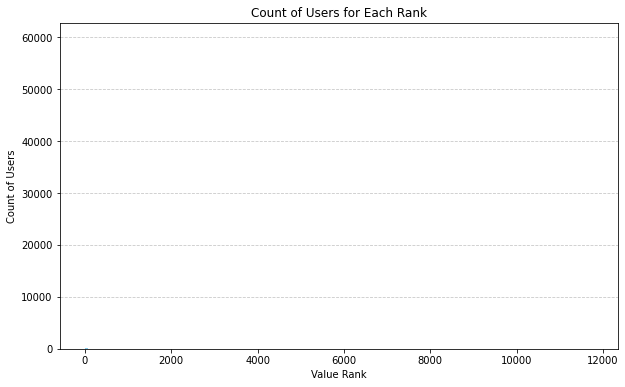

In [0]:
import matplotlib.pyplot as plt

# Group the DataFrame by the 'value' column (previously 'value_rank') and count the number of users
rank_counts = final_df.groupBy("value").count().orderBy("value")

# Convert the result to Pandas DataFrame for easier plotting
rank_counts_pd = rank_counts.toPandas()

# Plot the count of users for each rank
plt.figure(figsize=(10, 6))
plt.bar(rank_counts_pd["value"], rank_counts_pd["count"], color='skyblue')
plt.xlabel("Value Rank")
plt.ylabel("Count of Users")
plt.title("Count of Users for Each Rank")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [0]:
from pyspark.sql.functions import max, min

#checking the maximum and minimum value from the column value to see the game that was played for most hour 
max_value = final_df.agg(max("value").alias("max_value")).collect()[0]["max_value"]
min_value = final_df.agg(min("value").alias("min_value")).collect()[0]["min_value"]

print("Maximum value:", max_value)
print("Minimum value:", min_value)

Maximum value: 11754.0
Minimum value: 0.1


In [0]:
from pyspark.sql.functions import col

# Filter for the row with the maximum value
max_row = final_df.filter(col("value") == max_value).first()

print("Row with maximum value:")
print(max_row)

Row with maximum value:
Row(user=73017395, game="Sid Meier's Civilization V", value=11754.0, userId=11983.0, gameId=17.0)


In [0]:
# Filter for the row with the minimum value
min_row = final_df.filter(col("value") == min_value).first()

print("Row with minimum value:")
print(min_row)


Row with minimum value:
Row(user=100311267, game='Modular Combat', value=0.1, userId=266.0, gameId=622.0)


In [0]:
# from pyspark.ml.feature import Bucketizer
# from pyspark.sql.functions import col

# # Define the boundaries for bucketizing
# min_value = 0.1
# max_value = 11800

# # Define the number of buckets (ranks)
# num_buckets = 20

# # Define the boundaries for bucketizing
# boundaries = [i * ((max_value - min_value) / num_buckets) + min_value for i in range(num_buckets)]
# boundaries.append(max_value)

# # Define the bucketizer
# bucketizer = Bucketizer(splits=boundaries, inputCol="value", outputCol="value_rank")

# # Apply the bucketizer to the DataFrame
# df_with_rank = bucketizer.transform(final_df)

# # Show the DataFrame with the value ranks
# df_with_rank.show()


In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

# Define UDF to map value to rank
def map_to_rank(value):
    if value <= 10:
        return 1
    elif value <= 50:
        return 2
    elif value <= 90:
        return 3
    elif value <= 120:
        return 4
    elif value <= 175:
        return 5
    elif value <= 225:
        return 6
    elif value <= 400:
        return 7
    elif value <= 550:
        return 8
    elif value <= 800:
        return 9
    elif value <= 1500:
        return 10
    elif value <= 2500:
        return 11
    elif value <= 3500:
        return 12
    elif value <= 4500:
        return 13
    elif value <= 6000:
        return 14
    else:
        return 15

# Register UDF
map_to_rank_udf = udf(map_to_rank, IntegerType())

# Apply UDF to DataFrame
df_ranked = final_df.withColumn("rank", map_to_rank_udf(df["value"]))

# Show the result
df_ranked.show()

+---------+--------------------+-----+------+------+----+
|     user|                game|value|userId|gameId|rank|
+---------+--------------------+-----+------+------+----+
|100057229|Spore Galactic Ad...|  8.7|3358.0| 867.0|   1|
|100070732|  Wargame Red Dragon|129.0|2663.0| 823.0|   5|
|100096071|Euro Truck Simula...|156.0| 689.0| 120.0|   5|
|100096071|        Just Cause 2| 65.0| 689.0|  77.0|   3|
|100096071|LEGO MARVEL Super...|152.0| 689.0| 573.0|   5|
|100096071|           Robocraft|  3.6| 689.0|  12.0|   1|
|100208126|Insurgency Modern...| 21.0|6696.0| 399.0|   2|
|100311267|        APB Reloaded|  1.4| 266.0|  63.0|   1|
|100311267|AdVenture Capitalist|  1.7| 266.0|  93.0|   1|
|100311267|           Aftermath|  1.3| 266.0| 319.0|   1|
|100311267|            Defiance|  0.2| 266.0|  97.0|   1|
|100311267|Double Action Boo...|  0.4| 266.0| 259.0|   1|
|100311267|     F.E.A.R. Online|  1.4| 266.0| 420.0|   1|
|100311267|           Fallout 4| 12.0| 266.0| 135.0|   2|
|100311267|   

In [0]:
from pyspark.sql.functions import col

#Dropping the value function
df_ranked = df_ranked.drop("value")

# Rename the value_rank column to value
df_final = df_ranked.withColumnRenamed("rank", "value")

# Show the final DataFrame
df_final.show()

+---------+--------------------+------+------+-----+
|     user|                game|userId|gameId|value|
+---------+--------------------+------+------+-----+
|100057229|Spore Galactic Ad...|3358.0| 867.0|    1|
|100070732|  Wargame Red Dragon|2663.0| 823.0|    5|
|100096071|Euro Truck Simula...| 689.0| 120.0|    5|
|100096071|        Just Cause 2| 689.0|  77.0|    3|
|100096071|LEGO MARVEL Super...| 689.0| 573.0|    5|
|100096071|           Robocraft| 689.0|  12.0|    1|
|100208126|Insurgency Modern...|6696.0| 399.0|    2|
|100311267|        APB Reloaded| 266.0|  63.0|    1|
|100311267|AdVenture Capitalist| 266.0|  93.0|    1|
|100311267|           Aftermath| 266.0| 319.0|    1|
|100311267|            Defiance| 266.0|  97.0|    1|
|100311267|Double Action Boo...| 266.0| 259.0|    1|
|100311267|     F.E.A.R. Online| 266.0| 420.0|    1|
|100311267|           Fallout 4| 266.0| 135.0|    2|
|100311267|    Fistful of Frags| 266.0| 156.0|    1|
|100311267|   Heroes & Generals| 266.0|  15.0|

In [0]:
from pyspark.sql.types import IntegerType



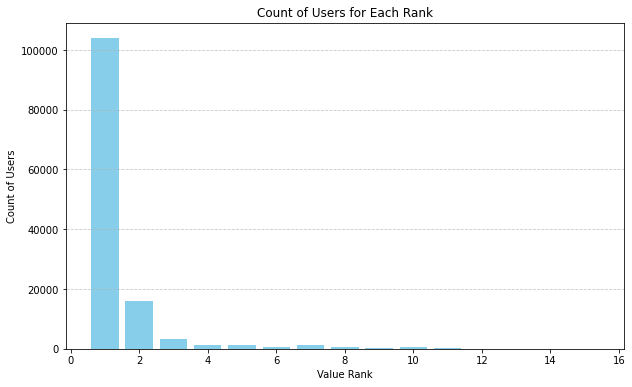

In [0]:
import matplotlib.pyplot as plt

# Group the DataFrame by the 'value' column (previously 'value_rank') and count the number of users
rank_counts = df_final.groupBy("value").count().orderBy("value")

# Convert the result to Pandas DataFrame for easier plotting
rank_counts_pd = rank_counts.toPandas()

# Plot the count of users for each rank
plt.figure(figsize=(10, 6))
plt.bar(rank_counts_pd["value"], rank_counts_pd["count"], color='skyblue')
plt.xlabel("Value Rank")
plt.ylabel("Count of Users")
plt.title("Count of Users for Each Rank")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [0]:
# Getting a user-item rating matrix
user_item_rating_df = df_final.select("userId", "gameId", "value")

In [0]:
user_item_rating_df.printSchema()

root
 |-- userId: double (nullable = false)
 |-- gameId: double (nullable = false)
 |-- value: integer (nullable = true)



In [0]:
# Split the data into training and test sets (assuming user_item_rating_df is defined)
(training, test) = user_item_rating_df.randomSplit([0.8, 0.2], seed=42)

test.show(25)

+------+------+-----+
|userId|gameId|value|
+------+------+-----+
|   0.0|  17.0|    8|
|   0.0|  77.0|    1|
|   0.0| 121.0|    1|
|   0.0| 254.0|    2|
|   0.0| 382.0|    1|
|   0.0| 413.0|    1|
|   0.0| 472.0|    1|
|   0.0| 689.0|    1|
|   0.0| 845.0|    1|
|   0.0| 863.0|    1|
|   0.0| 888.0|    1|
|   0.0| 967.0|    1|
|   0.0|1068.0|    2|
|   0.0|1114.0|    2|
|   0.0|1434.0|    1|
|   0.0|1758.0|    1|
|   0.0|2135.0|    2|
|   0.0|2987.0|    1|
|   0.0|3436.0|    1|
|   0.0|3746.0|    2|
|   0.0|3858.0|    1|
|   0.0|3992.0|    1|
|   1.0|   0.0|    1|
|   1.0|   9.0|    1|
|   1.0| 572.0|    5|
+------+------+-----+
only showing top 25 rows



In [0]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor

# Split the data into training and test sets (assuming user_item_rating_df is defined)
(training, test) = user_item_rating_df.randomSplit([0.8, 0.2], seed=42)

# Define ALS instance with desired parameters
als = ALS(maxIter=10, userCol="userId", itemCol="gameId", ratingCol="value", coldStartStrategy="drop")

# Train ALS model
als_model = als.fit(training)

# Generate predictions for the test set
predictions = als_model.transform(test)

# Evaluate the ALS model using RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="value", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("ALS RMSE:", rmse)

ALS RMSE: 0.6902239265155775


In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor

# Convert features to vector
feature_cols = ["userId", "gameId"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="assembled_features")
training = assembler.transform(training)
test = assembler.transform(test)

# Increase maxBins to handle large categorical features
gbt = GBTRegressor(featuresCol="assembled_features", labelCol="value", maxIter=10, maxBins=15000)

# Train GBT model
gbt_model = gbt.fit(training)

# Generate predictions for the test set
gbt_predictions = gbt_model.transform(test)

# Evaluate the GBT model using RMSE
gbt_rmse = evaluator.evaluate(gbt_predictions)
print("GBT RMSE:", gbt_rmse)

In [0]:
# from pyspark.ml.recommendation import ALS
# from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# from pyspark.ml.evaluation import RegressionEvaluator
# from pyspark.sql import SparkSession

# # Initialize Spark session
# spark = SparkSession.builder \
#     .appName("ALS Model Training and Evaluation") \
#     .getOrCreate()

# # Assuming user_item_rating_df is defined

# # Split the data into training and test sets
# (training, test) = user_item_rating_df.randomSplit([0.8, 0.2], seed=42)

# # Define ALS instance with desired parameters
# als = ALS(maxIter=10, userCol="userId", itemCol="gameId", ratingCol="value",
#           coldStartStrategy="drop")

# # Define a grid of hyperparameters to tune
# param_grid = ParamGridBuilder() \
#              .addGrid(als.rank, [10, 20, 30]) \
#              .addGrid(als.regParam, [0.01, 0.05, 0.1]) \
#              .build()

# # Define an evaluator
# evaluator = RegressionEvaluator(metricName="rmse", labelCol="value", predictionCol="prediction")

# # Create a CrossValidator
# cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

# # Train the model with cross-validation
# cv_model = cv.fit(training)

# # Get the best model from cross-validation
# best_model = cv_model.bestModel

# # Use the best model for predictions on the test set
# predictions = best_model.transform(test)

# # Evaluate the model on the test set
# rmse = evaluator.evaluate(predictions)
# print(f"Root Mean Squared Error (RMSE) on test set: {rmse}")


In [0]:
# Log the best model and its parameters
mlflow.spark.log_model(best_model, "als-model")
best_params = best_model.extractParamMap()
mlflow.log_params(best_params)

In [0]:
# Evaluate the model on the test set
predictions = best_model.transform(test)
rmse = evaluator.evaluate(predictions)
mlflow.log_metric("rmse", rmse)
print(f"Root Mean Squared Error (RMSE) on test data: {rmse}")

# Generate top 10 game recommendations for a user
user_id = 0.0 
user_recs = best_model.recommendForUserSubset(user_item_rating_df, [user_id], 5)